In [1]:
%load_ext autoreload
%aimport fqi.dataset_preprocessing, fqi.utils
%autoreload 1

In [2]:
import sys
import os

import pickle
import argparse
from trlib.policies.valuebased import EpsilonGreedy
from trlib.policies.qfunction import ZeroQ
from sklearn.ensemble.forest import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from trlib.algorithms.reinforcement.fqi_driver import FQIDriver
from trlib.environments.trackEnv import TrackEnv
from fqi.dataset_preprocessing import *
from fqi.fqi_evaluate import run_evaluation
from fqi.et_tuning import run_tuning
from matplotlib import pyplot as plt
from fqi.result_plot import heatmap, annotate_heatmap
import matplotlib
pd.options.display.max_columns = None

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
data_path = os.path.join(file_path, '..', '..', '..', '..', '..', '..', '..', 'data',
                                             'ferrari', 'driver', 'datasets', 'same_setup', 'csv')
track_file_name = 'ds_with_last_budapest_10'
rt_file_name = 'no_proc_rt_same_setup_budapest'

In [4]:
simulation = pd.read_csv(os.path.join(data_path, track_file_name + '.csv'))

In [5]:
dataset = prepare_dataset(os.path.join(data_path, track_file_name + '.csv'),
                              os.path.join(data_path, rt_file_name + '.csv'),
                              reward_function='progress', delta_t=0)

In [6]:
cols = ['t'] + state_cols + action_cols + ['r'] + state_prime_cols + ['absorbing']
dataset[['NLap'] + cols]

NLap    t  xCarWorld  yCarWorld  positionReferenceX  \
1  0     1.0  0.0   493.0193  -34.37362          493.607056   
   1     1.0  0.0   488.1724  -40.08960          488.885040   
   2     1.0  0.0   483.3096  -45.85862          484.127350   
   3     1.0  0.0   478.4296  -51.67754          479.335938   
   4     1.0  0.0   473.5356  -57.54678          474.511963   
   5     1.0  0.0   468.6298  -63.46545          469.658173   
   6     1.0  0.0   463.7112  -69.43072          464.776855   
   7     1.0  0.0   458.7805  -75.44118          459.869110   
   8     1.0  0.0   453.8369  -81.49455          454.936249   
   9     1.0  0.0   448.8783  -87.58657          449.977600   
   10    1.0  0.0   443.9016  -93.71316          444.990173   
   11    1.0  0.0   438.9007  -99.86797          439.972076   
   12    1.0  0.0   433.8741 -106.04830          434.926483   
   13    1.0  0.0   428.8268 -112.25830          429.858948   
   14    1.0  0.0   423.7584 -118.49590          424.769318   
   15    1.0  0.0   418.6653 -124.75580          419.657227   
   16    1.0  0.0   413.5497 -131.03970          414.526031   
   17    1.0  0.0   408.4128 -137.34710          409.376740   
   18    1.0  0.0   403.2519 -143.67500          404.210846   
   19    1.0  0.0   398.0688 -150.02400          399.031219   
   20    1.0  0.0   392.8653 -156.39440          393.839844   
   21    1.0  0.0   387.6391 -162.78270          388.637146   
   22    1.0  0.0   382.3931 -169.19080          383.424805   
   23    1.0  0.0   377.1319 -175.62090          378.200439   
   24    1.0  0.0   371.8539 -182.07090          372.963562   
   25    1.0  0.0   366.5581 -188.53870          367.713379   
   26    1.0  0.0   361.2484 -195.02620          362.449982   
   27    1.0  0.0   355.9242 -201.53250          357.171326   
   28    1.0  0.0   350.5848 -208.05560          351.877594   
   29    1.0  0.0   345.2325 -214.59590          346.571228   
...      ...  ...        ...        ...                 ...   
56 191  56.0  0.0    28.3202 -470.79630           38.618469   
   192  56.0  0.0    28.3202 -470.79630           38.618469   
   193  56.0  0.0    28.3202 -470.79630           38.618469   
   194  56.0  0.0    28.3202 -470.79630           38.618469   
   195  56.0  0.0    28.3202 -470.79630           38.618469   
   196  56.0  0.0    28.3202 -470.79630           38.618469   
   197  56.0  0.0    28.3202 -470.79630           38.618469   
   198  56.0  0.0    28.3202 -470.79630           38.618469   
   199  56.0  0.0    28.3202 -470.79630           38.618469   
   200  56.0  0.0    28.3202 -470.79630           38.618469   
   201  56.0  0.0    28.3202 -470.79630           38.618469   
   202  56.0  0.0    28.3202 -470.79630           38.618469   
   203  56.0  0.0    28.3202 -470.79630           38.618469   
   204  56.0  0.0    28.3202 -470.79630           38.618469   
   205  56.0  0.0    28.3202 -470.79630           38.618469   
   206  56.0  0.0    28.3202 -470.79630           38.618469   
   207  56.0  0.0    28.3202 -470.79630           38.618469   
   208  56.0  0.0    28.3202 -470.79630           38.618469   
   209  56.0  0.0    28.3202 -470.79630           38.618469   
   210  56.0  0.0    28.3202 -470.79630           38.618469   
   211  56.0  0.0    28.3202 -470.79630           38.618469   
   212  56.0  0.0    28.3202 -470.79630           38.618469   
   213  56.0  0.0    28.3202 -470.79630           38.618469   
   214  56.0  0.0    28.3202 -470.79630           38.618469   
   215  56.0  0.0    28.3202 -470.79630           38.618469   
   216  56.0  0.0    28.3202 -470.79630           38.618469   
   217  56.0  0.0    28.3202 -470.79630           38.618469   
   218  56.0  0.0    28.3202 -470.79630           38.618469   
   219  56.0  0.0    28.3202 -470.79630           38.618469   
   220  56.0  0.0    28.3202 -470.79630           38.618469   

        positionReferenceY  nYawBody  nEngine  NGear  positionRho  \
1  0            -35.265152 -0.03

In [7]:
dataset[state_cols].describe()

,xCarWorld,yCarWorld,positionReferenceX,positionReferenceY,nYawBody,nEngine,NGear,positionRho,positionTheta,positionLeft,positionRight,positionRelativeX,positionRelativeY,actualCurvature,referenceCurvature,actualSpeedModule,referenceSpeedAngle,speedDifferenceVectorModule,speedDifferenceOfModules,actualAccelerationModule,referenceAccelerationAngle,accelerationDifferenceVectorModule,accelerationDifferenceOfModules,actualAccelerationX,actualAccelerationY,accelerationDiffX,accelerationDiffY,prevpBrakeF,prevaSteerWheel,prevrThrottlePedal
count,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000
mean,79.486465,64.685833,79.804130,64.649712,0.078585,10047.754511,5.146969,2.132677,0.061524,0.501721,0.479598,0.053372,0.038062,0.007955,0.008358,54.660979,0.000028,4.213250,3.680009,20.100014,-0.028302,5.672551,1.947477,-0.144873,-3.636833,-0.014250,-0.468881,3.947869,-0.133550,63.875891
std,342.105430,289.475175,342.197825,289.315496,0.471164,1981.488489,1.687316,3.036275,1.866853,0.500003,0.499590,1.692065,3.301516,0.088227,0.045617,18.194716,0.001583,9.676961,9.892051,11.906905,0.540601,6.849797,7.033803,11.356268,20.089356,6.118555,6.437513,11.539734,0.833693,41.829137
min,-625.446500,-523.457900,-598.669006,-518.276367,-3.357393,0.000000,0.000000,0.000000,-3.141543,0.000000,0.000000,-5.701477,-61.093842,-1.570796,-0.086252,0.021958,0.000000,0.000000,-8.270027,0.010765,-3.141593,0.000000,-44.466316,-58.221320,-49.024590,-49.563393,-57.897392,0.000000,-3.929274,0.000000
25%,-193.971825,-112.189050,-192.807098,-111.981735,-0.161755,9394.250000,4.000000,1.011845,-1.376228,0.000000,0.000000,-1.190599,-0.517509,-0.017835,-0.023022,40.332998,0.000000,0.418607,-0.250479,9.267547,-0.109518,1.593942,-0.928632,-4.075422,-20.631325,-1.311796,-2.282847,0.010303,-0.688560,14.302333
50%,127.743200,89.624295,127.727707,90.420120,0.023885,10611.000000,5.000000,1.711885,0.004753,1.000000,0.000000,0.000000,0.003586,0.000000,-0.000000,54.395548,0.000000,1.124859,0.687982,21.351892,-0.000000,3.466106,0.425268,2.892552,-1.346463,-0.090031,-0.160010,0.013233,-0.031060,88.520367
75%,368.906250,308.558600,369.996796,308.611450,0.480191,11280.750000,7.000000,2.563777,1.593744,1.000000,1.000000,1.331482,0.629108,0.047143,0.054921,69.765032,0.000000,3.376134,3.209840,29.120529,0.103810,6.850484,3.316145,6.955806,8.830854,1.380650,1.699451,0.023331,0.187019,100.000000
max,604.853900,546.580800,603.779663,543.059204,3.847980,13697.000000,8.000000,61.180931,3.141501,1.000000,1.000000,4.407196,50.738556,1.570796,0.091383,88.951576,0.102914,86.782822,86.782814,58.225998,3.141593,68.884544,49.564919,21.173100,53.916210,50.148308,68.516251,84.426247,3.926500,100.000000


In [8]:
corr_df = dataset.corr()

In [9]:
corr_df['r'][abs(corr_df['r'].values) > 0.3].sort_values()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


speedDifferenceOfModules                   -0.893571
speedDifferenceOfModules_prime             -0.893537
speedDifferenceVectorModule                -0.880597
speedDifferenceVectorModule_prime          -0.880483
accelerationDifferenceVectorModule         -0.603306
accelerationDifferenceVectorModule_prime   -0.598178
accelerationDifferenceOfModules_prime      -0.559323
accelerationDifferenceOfModules            -0.549792
positionRho                                -0.420847
positionRho_prime                          -0.419088
referenceAccelerationAngle                  0.304150
referenceAccelerationAngle_prime            0.306332
NGear                                       0.309799
NGear_prime                                 0.311276
prevrThrottlePedal_prime                    0.327984
rThrottlePedal                              0.327984
prevrThrottlePedal                          0.336773
actualSpeedModule_prime                     0.463848
actualSpeedModule                           0.

## Speed features
- the two delta features have high correlation thus we can use only one of them
- reference speed angle is almost constant so it can be removed

Thus meaningful features are:
- actual speed module 
- diff of modules

In [10]:
speed_cols = ['speedDifferenceVectorModule', 'speedDifferenceOfModules', 'actualSpeedModule', 
       'referenceSpeedAngle']

corr_df[speed_cols].loc[speed_cols]

,speedDifferenceVectorModule,speedDifferenceOfModules,actualSpeedModule,referenceSpeedAngle
speedDifferenceVectorModule,1.000000,0.991641,-0.427233,0.148145
speedDifferenceOfModules,0.991641,1.000000,-0.422519,0.145880
actualSpeedModule,-0.427233,-0.422519,1.000000,-0.053281
referenceSpeedAngle,0.148145,0.145880,-0.053281,1.000000


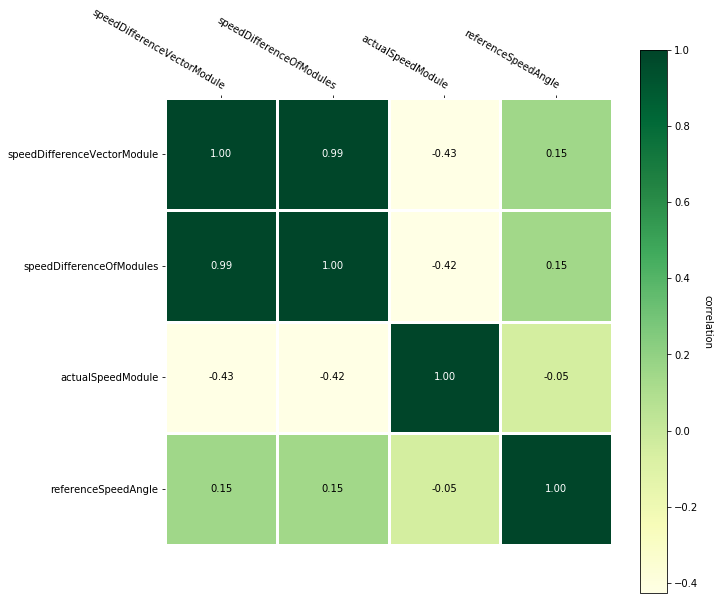

In [11]:
f, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(corr_df[speed_cols].loc[speed_cols].values, speed_cols, speed_cols, ax=ax,
                  cmap="YlGn", cbarlabel="correlation")
t = annotate_heatmap(im, valfmt='{x:.2f}')

In [12]:
dataset[speed_cols].describe()

,speedDifferenceVectorModule,speedDifferenceOfModules,actualSpeedModule,referenceSpeedAngle
count,40682.000000,40682.000000,40682.000000,40682.000000
mean,4.213250,3.680009,54.660979,0.000028
std,9.676961,9.892051,18.194716,0.001583
min,0.000000,-8.270027,0.021958,0.000000
25%,0.418607,-0.250479,40.332998,0.000000
50%,1.124859,0.687982,54.395548,0.000000
75%,3.376134,3.209840,69.765032,0.000000
max,86.782822,86.782814,88.951576,0.102914


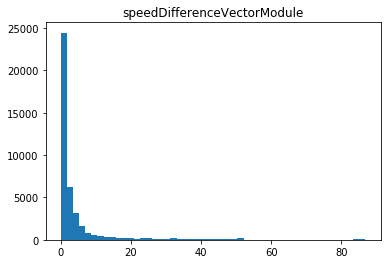

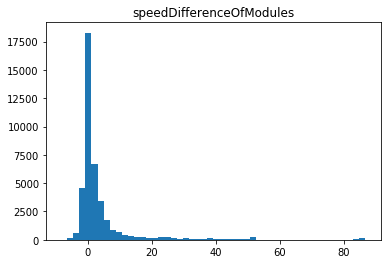

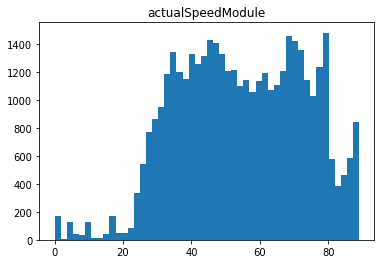

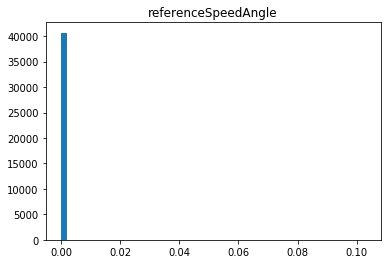

In [13]:
for c in speed_cols:
    f = plt.figure()
    plt.hist(dataset[c], 50)
    plt.title(c)

## Acceleration features
Even if the accleration angle is not constant its meaning is missleading because the x,y coordinates of the car are relative to the car horientation thus, the angle is the angle between two vectors with different reference systems.
Thus meaningful features are:
- actual acceleration x,y
- acceleration diff x
- acceleration diff y

In [14]:
acc_cols = ['actualAccelerationModule', 'referenceAccelerationAngle',
            'accelerationDifferenceVectorModule', 'accelerationDifferenceOfModules',
            'actualAccelerationX', 'actualAccelerationY', 'accelerationDiffX', 'accelerationDiffY']
corr_df[acc_cols].loc[acc_cols]

,actualAccelerationModule,referenceAccelerationAngle,accelerationDifferenceVectorModule,accelerationDifferenceOfModules,actualAccelerationX,actualAccelerationY,accelerationDiffX,accelerationDiffY
actualAccelerationModule,1.000000,0.100247,-0.023482,-0.152754,-0.438471,-0.119719,0.065845,0.058634
referenceAccelerationAngle,0.100247,1.000000,-0.054009,-0.107874,0.006298,0.034541,-0.045779,-0.057837
accelerationDifferenceVectorModule,-0.023482,-0.054009,1.000000,0.580457,-0.187715,0.038030,-0.102865,-0.179152
accelerationDifferenceOfModules,-0.152754,-0.107874,0.580457,1.000000,-0.003267,0.027197,-0.460670,-0.235675
actualAccelerationX,-0.438471,0.006298,-0.187715,-0.003267,1.000000,-0.027976,-0.100293,0.006489
actualAccelerationY,-0.119719,0.034541,0.038030,0.027197,-0.027976,1.000000,0.010408,0.144579
accelerationDiffX,0.065845,-0.045779,-0.102865,-0.460670,-0.100293,0.010408,1.000000,-0.005274
accelerationDiffY,0.058634,-0.057837,-0.179152,-0.235675,0.006489,0.144579,-0.005274,1.000000


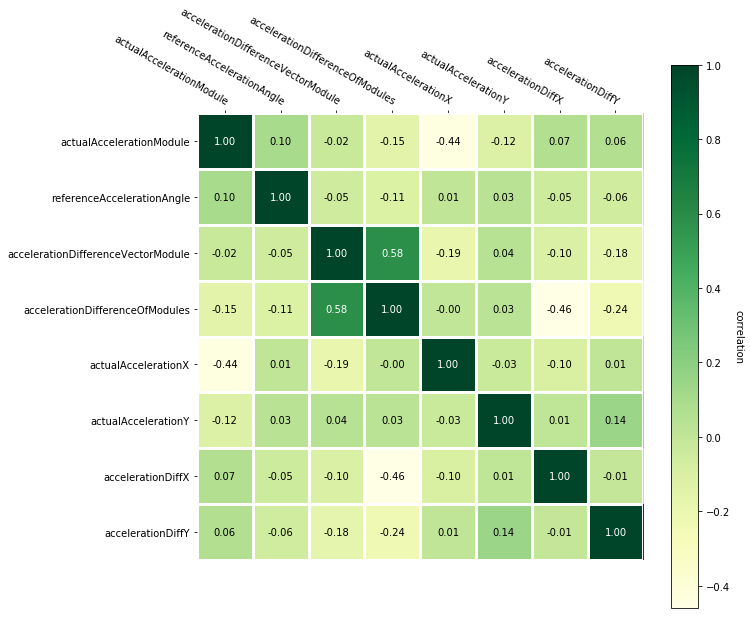

In [15]:
f, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(corr_df[acc_cols].loc[acc_cols].values, acc_cols, acc_cols, ax=ax,
                  cmap="YlGn", cbarlabel="correlation")
t = annotate_heatmap(im, valfmt='{x:.2f}')

In [16]:
dataset[acc_cols].describe()

,actualAccelerationModule,referenceAccelerationAngle,accelerationDifferenceVectorModule,accelerationDifferenceOfModules,actualAccelerationX,actualAccelerationY,accelerationDiffX,accelerationDiffY
count,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000,40682.000000
mean,20.100014,-0.028302,5.672551,1.947477,-0.144873,-3.636833,-0.014250,-0.468881
std,11.906905,0.540601,6.849797,7.033803,11.356268,20.089356,6.118555,6.437513
min,0.010765,-3.141593,0.000000,-44.466316,-58.221320,-49.024590,-49.563393,-57.897392
25%,9.267547,-0.109518,1.593942,-0.928632,-4.075422,-20.631325,-1.311796,-2.282847
50%,21.351892,-0.000000,3.466106,0.425268,2.892552,-1.346463,-0.090031,-0.160010
75%,29.120529,0.103810,6.850484,3.316145,6.955806,8.830854,1.380650,1.699451
max,58.225998,3.141593,68.884544,49.564919,21.173100,53.916210,50.148308,68.516251


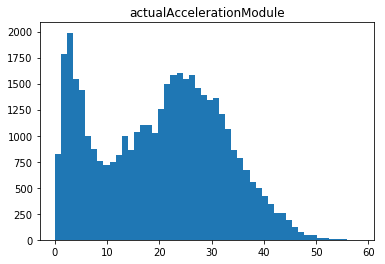

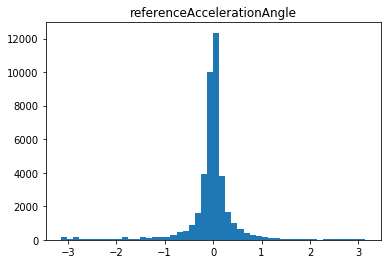

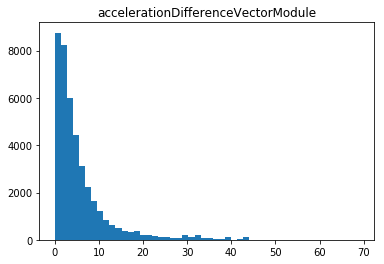

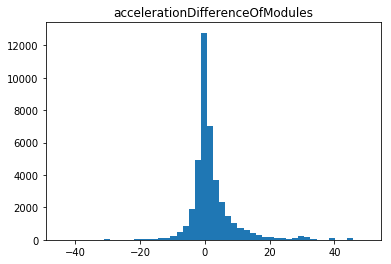

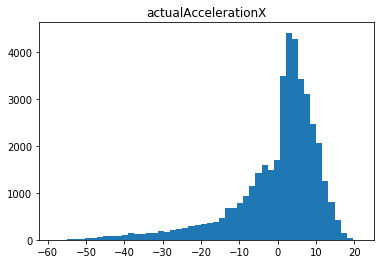

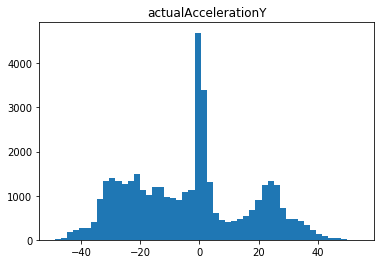

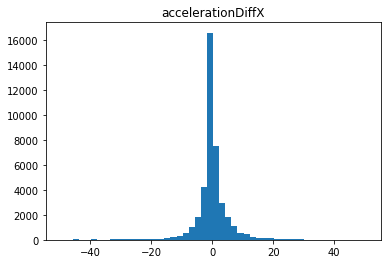

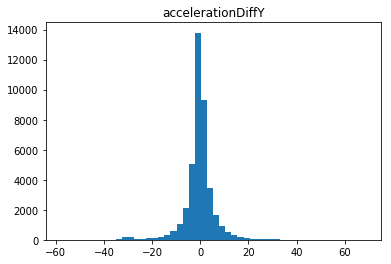

In [17]:
for c in acc_cols:
    f = plt.figure()
    plt.hist(dataset[c], 50)
    plt.title(c)

## Position
Useful features are:
- x,y car world
- position Rho
- relative x,y
- curvatures

In [18]:
pos_cols = ['xCarWorld', 'yCarWorld', 'positionReferenceX', 'positionReferenceY',
           'positionRho', 'positionTheta', 'positionLeft', 'positionRight',
            'positionRelativeX', 'positionRelativeY', 'actualCurvature', 'referenceCurvature']
corr_df[pos_cols].loc[pos_cols]

,xCarWorld,yCarWorld,positionReferenceX,positionReferenceY,positionRho,positionTheta,positionLeft,positionRight,positionRelativeX,positionRelativeY,actualCurvature,referenceCurvature
xCarWorld,1.000000,-0.141007,0.999970,-0.141739,-0.026190,-0.075675,-0.098774,0.097519,-0.000379,-0.102561,-0.031386,-0.089164
yCarWorld,-0.141007,1.000000,-0.141501,0.999960,0.001163,0.078781,0.127804,-0.129151,-0.015848,0.001987,-0.009535,-0.001603
positionReferenceX,0.999970,-0.141501,1.000000,-0.142242,-0.020924,-0.075500,-0.098786,0.097568,-0.000630,-0.103954,-0.031352,-0.089280
positionReferenceY,-0.141739,0.999960,-0.142242,1.000000,0.000790,0.079393,0.128257,-0.129604,-0.016080,0.006467,-0.009425,-0.001184
positionRho,-0.026190,0.001163,-0.020924,0.000790,1.000000,-0.001392,0.006869,0.018885,-0.030246,-0.143319,-0.004314,-0.009615
positionTheta,-0.075675,0.078781,-0.075500,0.079393,-0.001392,1.000000,0.812423,-0.811863,-0.024959,0.303348,0.035210,0.030921
positionLeft,-0.098774,0.127804,-0.098786,0.128257,0.006869,0.812423,1.000000,-0.963305,-0.032782,0.361664,0.045157,0.051037
positionRight,0.097519,-0.129151,0.097568,-0.129604,0.018885,-0.811863,-0.963305,1.000000,0.034861,-0.361443,-0.045229,-0.050838
positionRelativeX,-0.000379,-0.015848,-0.000630,-0.016080,-0.030246,-0.024959,-0.032782,0.034861,1.000000,-0.018715,0.003821,0.000992
positionRelativeY,-0.102561,0.001987,-0.103954,0.006467,-0.143319,0.303348,0.361664,-0.361443,-0.018715,1.000000,0.072906,0.154283


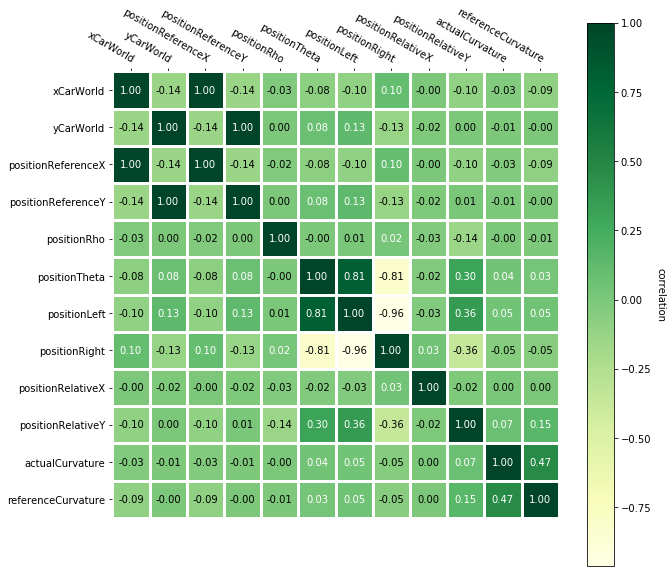

In [19]:
f, ax = plt.subplots(figsize=(10,10))
im, cbar = heatmap(corr_df[pos_cols].loc[pos_cols].values, pos_cols, pos_cols, ax=ax,
                  cmap="YlGn", cbarlabel="correlation")
t = annotate_heatmap(im, valfmt='{x:.2f}')

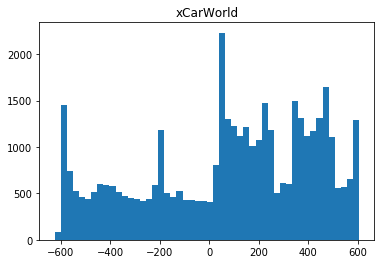

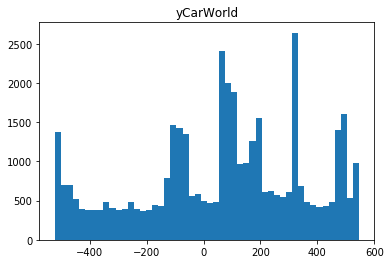

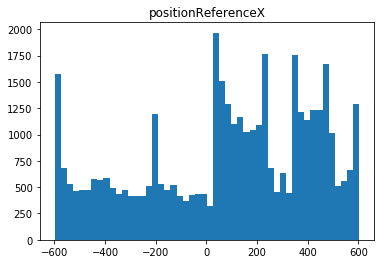

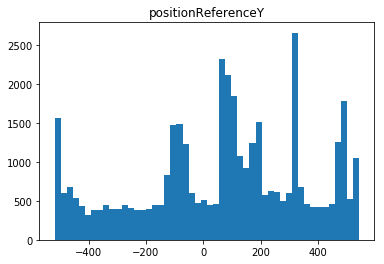

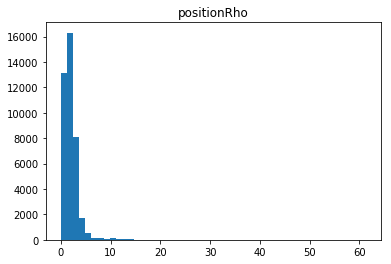

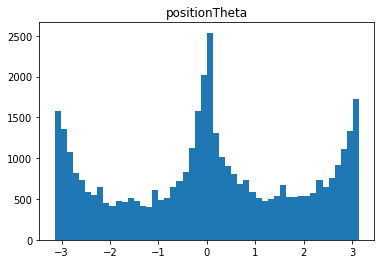

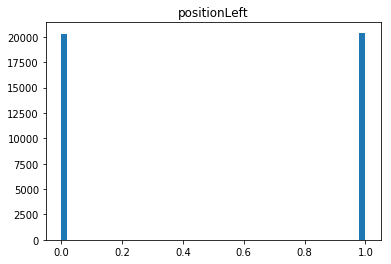

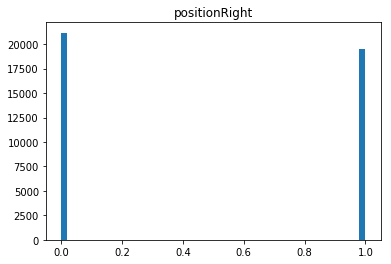

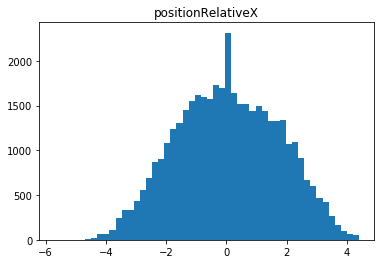

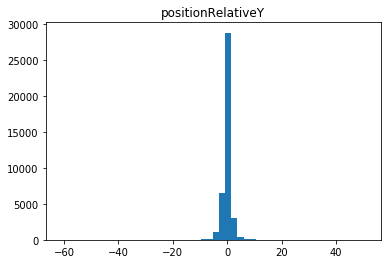

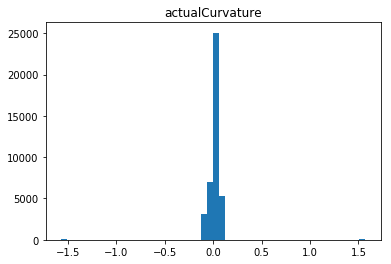

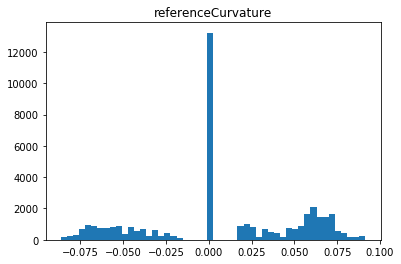

In [20]:
for c in pos_cols:
    f = plt.figure()
    plt.hist(dataset[c], 50)
    plt.title(c)

## Other features

In [21]:
oth_cols = ['nYawBody', 'nEngine', 'NGear']
corr_df[oth_cols].loc[state_cols]

,nYawBody,nEngine,NGear
xCarWorld,-0.061408,0.059469,0.030355
yCarWorld,-0.015186,0.077806,-0.012722
positionReferenceX,-0.061468,0.058080,0.030103
positionReferenceY,-0.014870,0.078212,-0.012729
nYawBody,1.000000,-0.026226,-0.074886
nEngine,-0.026226,1.000000,0.421738
NGear,-0.074886,0.421738,1.000000
positionRho,-0.019814,-0.293018,-0.038302
positionTheta,0.060612,-0.048757,-0.065026
positionLeft,0.080837,-0.050961,-0.103691


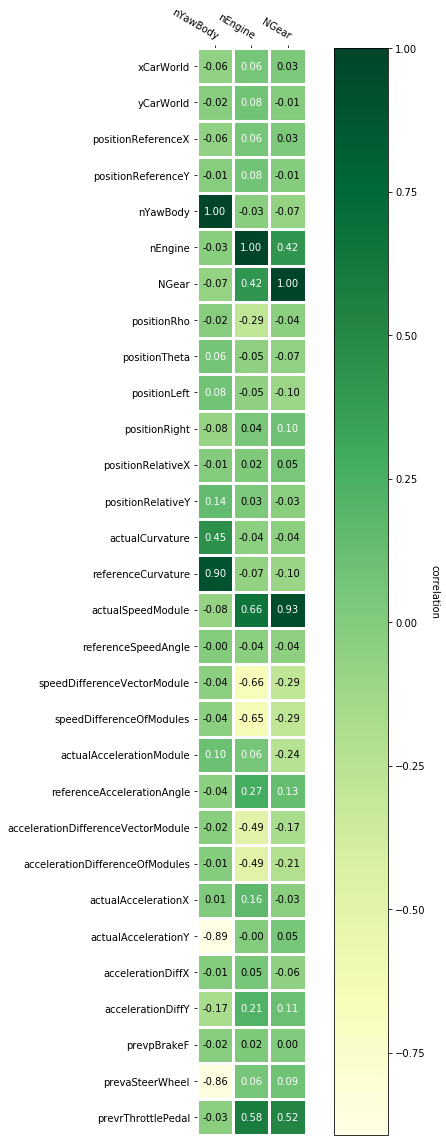

In [22]:
f, ax = plt.subplots(figsize=(10,20))
im, cbar = heatmap(corr_df[oth_cols].loc[state_cols].values, state_cols, oth_cols, ax=ax,
                  cmap="YlGn", cbarlabel="correlation")
t = annotate_heatmap(im, valfmt='{x:.2f}')

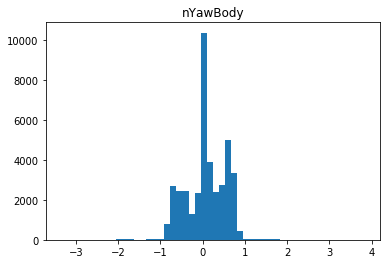

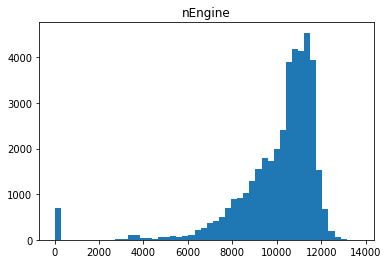

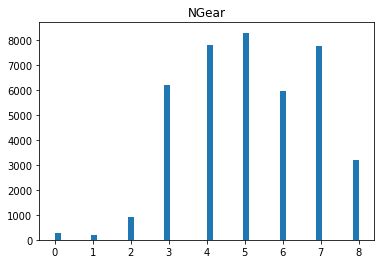

In [23]:
for c in oth_cols:
    f = plt.figure()
    plt.hist(dataset[c], 50)
    plt.title(c)

# Final selection of state features

In [28]:
chosen_state_cols = ['xCarWorld', 'yCarWorld', 'positionRelativeX', 'positionRelativeY', 'positionRho',
              'positionTheta',
              'actualCurvature', 'referenceCurvature',
              'actualSpeedModule', 'speedDifferenceOfModules',
              'actualAccelerationX', 'actualAccelerationY', 'accelerationDiffX', 'accelerationDiffY',
              'nYawBody', 'nEngine', 'NGear']

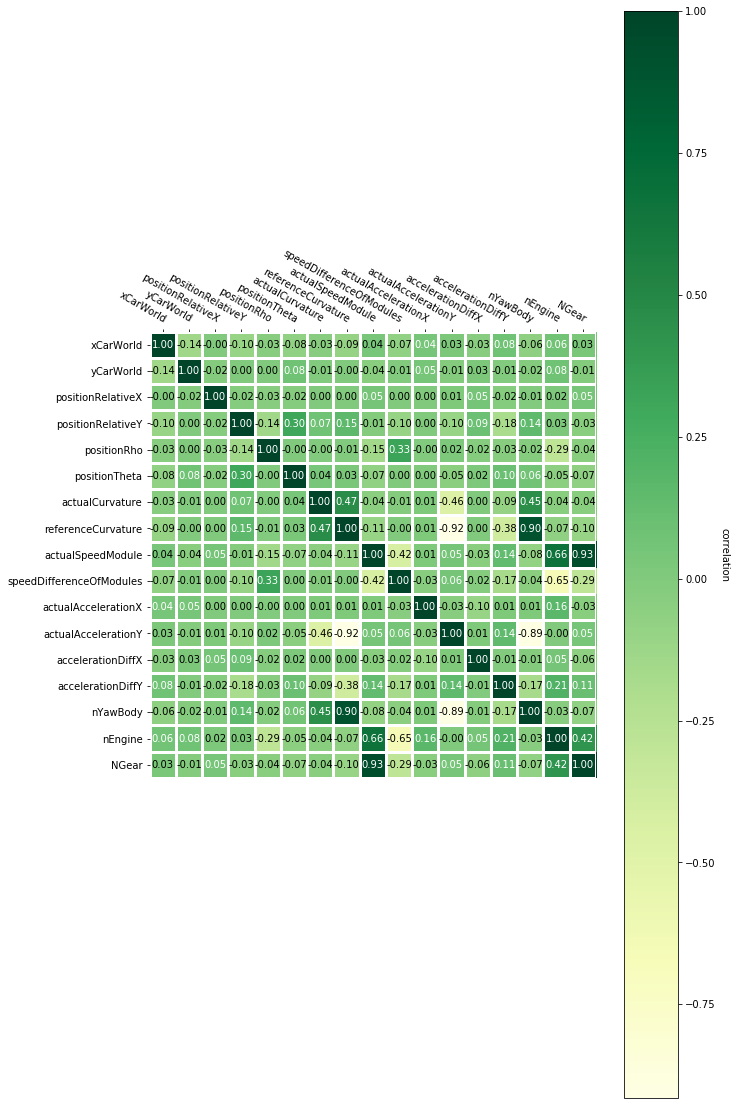

In [29]:
f, ax = plt.subplots(figsize=(10,20))
im, cbar = heatmap(corr_df[chosen_state_cols].loc[chosen_state_cols].values, chosen_state_cols, chosen_state_cols, ax=ax,
                  cmap="YlGn", cbarlabel="correlation")
t = annotate_heatmap(im, valfmt='{x:.2f}')